In [1]:
import pandas as pd
import json
import csv

In [2]:
df_census = pd.read_csv('acs2017_census_tract_data.csv')
df_covid = pd.read_csv('COVID_county_data.csv')

In [3]:
df_census[['County', 'State', 'TotalPop', 'IncomePerCap', 'Poverty']].tail(15)

,County,State,TotalPop,IncomePerCap,Poverty
73986,Yabucoa Municipio,Puerto Rico,2196,8009.0,54.1
73987,Yabucoa Municipio,Puerto Rico,4146,6902.0,69.4
73988,Yabucoa Municipio,Puerto Rico,5371,10930.0,43.6
73989,Yabucoa Municipio,Puerto Rico,0,NaN,NaN
73990,Yauco Municipio,Puerto Rico,2462,4918.0,75.8
73991,Yauco Municipio,Puerto Rico,3375,6853.0,56.1
73992,Yauco Municipio,Puerto Rico,3132,8198.0,53.6
73993,Yauco Municipio,Puerto Rico,3442,6023.0,63.2
73994,Yauco Municipio,Puerto Rico,4234,10642.0,29.2
73995,Yauco Municipio,Puerto Rico,2988,8078.0,48.4


In [4]:
df_covid

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
...,...,...,...,...,...,...
1050253,2021-02-20,Sweetwater,Wyoming,56037.0,3645,34.0
1050254,2021-02-20,Teton,Wyoming,56039.0,3318,9.0
1050255,2021-02-20,Uinta,Wyoming,56041.0,2024,12.0
1050256,2021-02-20,Washakie,Wyoming,56043.0,876,26.0


### A. Aggregate Census Data to County Level

Create a python program that produces a one-row-per-county version of the ACS data set. To do this you will need to think about how to properly aggregate Census Tract-level data into County-level summaries. 

In [5]:
census_cols = ['County', 'State', 'TotalPop', 'IncomePerCap', 'Poverty']
agg_fns = { 'TotalPop': ['sum'], 'IncomePerCap': ['sum'], 'Poverty': ['mean'] }
df_census_agg = df_census[census_cols].groupby(['County', 'State']).agg(agg_fns)
df_census_agg

TotalPop IncomePerCap    Poverty
                                     sum          sum       mean
County           State                                          
Abbeville County South Carolina    24788     116417.0  22.183333
Acadia Parish    Louisiana         62607     257451.0  21.933333
Accomack County  Virginia          32840     198158.0  20.112500
Ada County       Idaho            435117    1927687.0  12.608475
Adair County     Iowa               7192      86522.0   9.566667
...                                  ...          ...        ...
Yuma County      Arizona          204281    1138421.0  19.357692
                 Colorado          10109      49682.0  14.350000
Zapata County    Texas             14415      53653.0  32.566667
Zavala County    Texas             12152      50641.0  41.375000
Ziebach County   South Dakota       2837      13461.0  43.100000

[3220 rows x 3 columns]

Show your aggregated county-level data rows for the following counties: Loudon County Virginia, Washington County Oregon, Harlan County Kentucky, Malheur County Oregon


In [6]:
print(df_census_agg.loc[('Loudoun County', 'Virginia')])
print(df_census_agg.loc[('Washington County', 'Oregon')])
print(df_census_agg.loc[('Harlan County', 'Kentucky')])
print(df_census_agg.loc[('Malheur County', 'Oregon')])

TotalPop      sum     3.745580e+05
IncomePerCap  sum     3.225025e+06
Poverty       mean    3.884375e+00
Name: (Loudoun County, Virginia), dtype: float64
TotalPop      sum     5.720710e+05
IncomePerCap  sum     3.636965e+06
Poverty       mean    1.044615e+01
Name: (Washington County, Oregon), dtype: float64
TotalPop      sum      27548.000000
IncomePerCap  sum     176114.000000
Poverty       mean        33.318182
Name: (Harlan County, Kentucky), dtype: float64
TotalPop      sum      30421.000000
IncomePerCap  sum     125765.000000
Poverty       mean        24.414286
Name: (Malheur County, Oregon), dtype: float64


### B. Simplify the COVID Data

You can simplify the COVID data along the time dimension. The COVID data set contains day-level resolution data from (approximately) March of 2020 through February of 2021. However, you will only need four data points per county: total cases, total deaths, cases reported during December of 2020 and deaths reported during December 2020. 

In [7]:
cols = ['county', 'state', 'cases', 'deaths']
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid_dec = df_covid.loc[(df_covid['date'] >= '2020-12-01') & (df_covid['date'] <= '2020-12-31')]
df_covid_dec_agg = (
    df_covid_dec[cols]
        .groupby(['county', 'state'])
        .sum()
        .rename(columns={"cases": "Dec2020Cases", "deaths": "Dec2020Deaths"})
    )
df_covid_agg = df_covid[cols].groupby(['county', 'state']).sum().join(df_covid_dec_agg) 
df_covid_agg 

cases   deaths  Dec2020Cases  Dec2020Deaths
county    state                                                        
Abbeville South Carolina   206727   3934.0       35084.0          715.0
Acadia    Louisiana        880935  27877.0      141781.0         4053.0
Accomack  Virginia         389637   5758.0       47215.0          712.0
Ada       Idaho           5230256  50724.0     1007571.0         9301.0
Adair     Iowa              70396   1792.0       16315.0          462.0
...                           ...      ...           ...            ...
Yuma      Arizona         4445946  96197.0      717423.0        13887.0
          Colorado          68447   1016.0       14075.0          173.0
Zapata    Texas            139632   2031.0       23503.0          281.0
Zavala    Texas            153660   4211.0       26725.0          755.0
Ziebach   South Dakota      34763    806.0        8247.0          219.0

[3274 rows x 4 columns]

Show your simplified COVID data for the counties listed above.

In [8]:
print(df_covid_agg.loc[('Loudoun', 'Virginia')])
print(df_covid_agg.loc[('Washington', 'Oregon')])
print(df_covid_agg.loc[('Harlan', 'Kentucky')])
print(df_covid_agg.loc[('Malheur', 'Oregon')])

cases            2496450.0
deaths             35820.0
Dec2020Cases      376223.0
Dec2020Deaths       4729.0
Name: (Loudoun, Virginia), dtype: float64
cases            2157339.0
deaths             22455.0
Dec2020Cases      424620.0
Dec2020Deaths       3860.0
Name: (Washington, Oregon), dtype: float64
cases            205984.0
deaths             3994.0
Dec2020Cases      38959.0
Dec2020Deaths       506.0
Name: (Harlan, Kentucky), dtype: float64
cases            453634.0
deaths             7770.0
Dec2020Cases      82916.0
Dec2020Deaths      1465.0
Name: (Malheur, Oregon), dtype: float64


### C. Integrate COVID Data with ACS Data

Create a single pandas DataFrame containing one row per county and using the columns described above. You are free to add additional columns if needed. For example, you might want to normalize all of the COVID data by the population of each county so that you have a consistent “number of cases/deaths per 100000 residents” value for each county.

In [9]:
df_census_agg = df_census_agg.rename(
    index=dict(zip(list(map(lambda index: index[0],
                            df_census_agg.index.values.tolist())), 
                   list(map(lambda index: index[0].split()[0], 
                            df_census_agg.index.values)))), 
    inplace=False)
df_census_agg.index.names = ["county", "state"]
df_integrated = df_census_agg.join(df_covid_agg)
df_integrated

C:\Users\74006\miniconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


(TotalPop, sum)  (IncomePerCap, sum)  \
county    state                                                  
Abbeville South Carolina            24788             116417.0   
Acadia    Louisiana                 62607             257451.0   
Accomack  Virginia                  32840             198158.0   
Ada       Idaho                    435117            1927687.0   
Adair     Iowa                       7192              86522.0   
...                                   ...                  ...   
Yuma      Arizona                  204281            1138421.0   
          Colorado                  10109              49682.0   
Zapata    Texas                     14415              53653.0   
Zavala    Texas                     12152              50641.0   
Ziebach   South Dakota               2837              13461.0   

                          (Poverty, mean)      cases   deaths  Dec2020Cases  \
county    state                                                               
Abbeville South Carolina        22.183333   206727.0   3934.0       35084.0   
Acadia    Louisiana             21.933333   880935.0  27877.0      141781.0   
Accomack  Virginia              20.112500   389637.0   5758.0       47215.0   
Ada       Idaho                 12.608475  5230256.0  50724.0     1007571.0   
Adair     Iowa                   9.566667    70396.0   1792.0       16315.0   
...                                   ...        ...      ...           ...   
Yuma      Arizona               19.357692  4445946.0  96197.0      717423.0   
          Colorado              14.350000    68447.0   1016.0       14075.0   
Zapata    Texas                 32.566667   139632.0   2031.0       23503.0   
Zavala    Texas                 41.375000   153660.0   4211.0       26725.0   
Ziebach   South Dakota          43.100000    34763.0    806.0        8247.0   

                          Dec2020Deaths  
county    state                          
Abbeville South Carolina          715.0  
Acadia    Louisiana              4053.0  
Accomack  Virginia                712.0  
Ada       Idaho                  9301.0  
Adair     Iowa                    462.0  
...                                 ...  
Yuma      Arizona               13887.0  
          Colorado                173.0  
Zapata    Texas                   281.0  
Zavala    Texas                   755.0  
Ziebach   South Dakota            219.0  

[3220 rows x 7 columns]

 List your integrated data for all counties in the State of Oregon.

In [31]:
df_integrated_oregon = (
    df_integrated
        .xs("Oregon", level="state")
        .rename(columns={
            ('TotalPop', 'sum'): 'TotalPop',
            ('IncomePerCap', 'sum'): 'IncomePerCap',
            ('Poverty', 'mean'): 'Poverty',
        })
        .fillna(0)
        .astype({'cases': 'int64'}))
df_integrated_oregon

,TotalPop,IncomePerCap,Poverty,cases,deaths,Dec2020Cases,Dec2020Deaths
county,,,,,,,
Baker,15980,154241.0,15.000000,55586,663.0,11688.0,133.0
Benton,88249,538668.0,23.644444,180225,2304.0,34260.0,278.0
Clackamas,399962,3000217.0,9.320000,1284402,20040.0,261810.0,3125.0
Clatsop,38021,311931.0,12.481818,77666,287.0,14439.0,47.0
Columbia,50207,281097.0,12.530000,105324,1363.0,21459.0,266.0
Coos,62921,344348.0,17.415385,100097,969.0,18806.0,151.0
Crook,21717,95834.0,15.050000,55863,1134.0,11048.0,196.0
Curry,22377,134496.0,16.300000,30045,393.0,6741.0,72.0
Deschutes,175321,764025.0,12.208333,509974,4141.0,102490.0,563.0


### D. Analysis



The following shows that the calculation approach is wrong, thus the results obtained (0.92) is impacted by the population, so a non-linear relationship becomes linear.

In [54]:
df_integrated_oregon['PovertyPop'] = df_integrated_oregon['Poverty']*df_integrated_oregon['TotalPop']
R = df_integrated_oregon['cases'].corr(df_integrated_oregon['PovertyPop'])
R

0.9245550248599488

<AxesSubplot:xlabel='PovertyPop', ylabel='cases'>

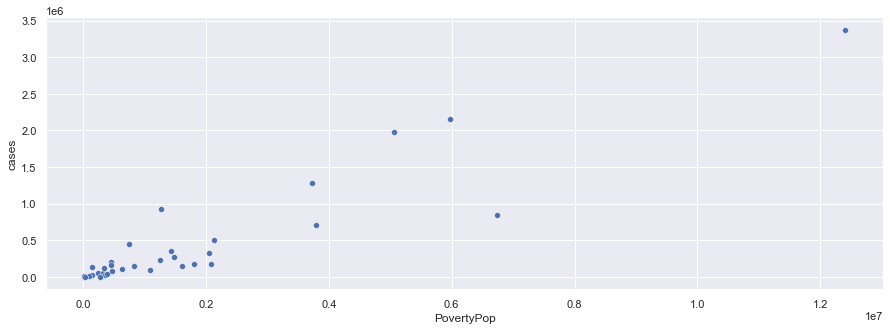

In [57]:
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,5)})
sns.scatterplot(data=df_integrated_oregon, x="PovertyPop", y="cases")

R-squared: 0.855


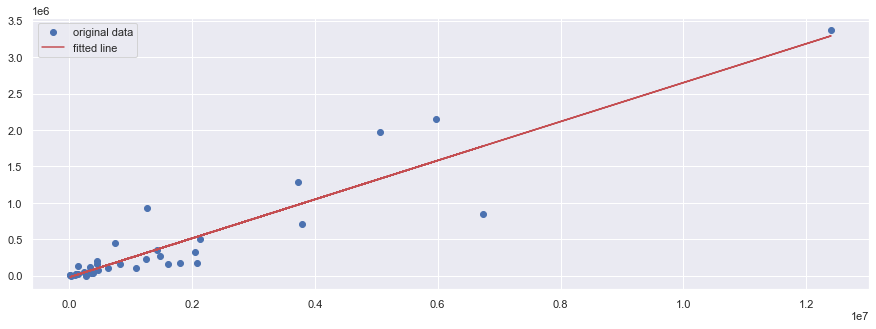

In [63]:
x, y = df_integrated_oregon['PovertyPop'], df_integrated_oregon['cases']
res = stats.linregress(x, y)
print(f"R-squared: {res.rvalue**2:.3f}")
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

The following shows the correct calculation.

0.24437821395123033


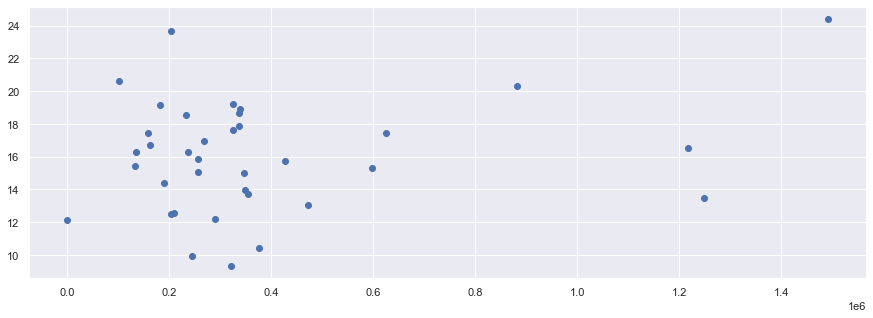

In [85]:
x, y = df_integrated_oregon['cases'] * 100000 / df_integrated_oregon['TotalPop'],  df_integrated_oregon['Poverty']
R = x.corr(y)
print(R)
plt.plot(x, y, 'o', label='data')
R = x.corr(y)

In [86]:
x, y = (
    df_integrated_oregon['deaths'] * 100000 / df_integrated_oregon['TotalPop'],  
    df_integrated_oregon['Poverty'])
R = x.corr(y)
print(R)

0.32704290486477905


In [87]:
x, y = (
    df_integrated_oregon['Dec2020Cases'] * 100000 / df_integrated_oregon['TotalPop'],  
    df_integrated_oregon['Dec2020Deaths'])
R = x.corr(y)
print(R)

0.19242570321808466
